# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, countDistinct, count, when, sum,col
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, MinMaxScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Creating a Spark session
spark = (SparkSession.builder 
                    .master("local") 
                    .appName("Creating Features") 
                    .getOrCreate())

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# Loading a dataset and marks RDD to be presisted
events = spark.read.json('mini_sparkify_event_data.json')
events.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [4]:
events.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
events.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
events.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,286500,278154,278154,286500,278154,228108,286500,278154,286500,286500,278154,286500,228108,286500,286500,278154,286500
1,mean,551.0852017937219,None,None,None,114.41421291448516,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1041.526554973822,Infinity,210.05459685863875,1.5409568898104834E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.76726201140994,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.7762634630741,NaN,31.50507848842214,1.5075439608226302E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",
4,max,ÃÂlafur Arnalds,Logged Out,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [7]:
events.groupBy("auth").agg(countDistinct("userId")).toPandas()

,auth,count(DISTINCT userId)
0,Logged Out,1
1,Cancelled,52
2,Guest,1
3,Logged In,225


In [8]:
events.groupBy("page").agg(count("userId")).toPandas()

,page,count(userId)
0,Cancel,52
1,Submit Downgrade,63
2,Thumbs Down,2546
3,Home,14457
4,Downgrade,2055
5,Roll Advert,3933
6,Logout,3226
7,Save Settings,310
8,Cancellation Confirmation,52
9,About,924


In [9]:
events.agg(countDistinct("artist"), 
           countDistinct('song'),
           countDistinct('userAgent')).toPandas()

,count(DISTINCT artist),count(DISTINCT song),count(DISTINCT userAgent)
0,17655,58480,56


In [10]:
# Filters to only userIDs associated with churned users
churned_users = (events.filter(events.page == 'Cancellation Confirmation')
                       .select('userId')
                       .distinct()
                       .rdd.flatMap(lambda x: x)
                       .collect())

# Creates a new field that indicates whether a user churned
events = events.withColumn('Churn', 
                            when(events.userId.isin(churned_users), 1).otherwise(0))

In [11]:
churned_users

['125',
 '51',
 '54',
 '100014',
 '101',
 '29',
 '100021',
 '87',
 '73',
 '3',
 '28',
 '100022',
 '100025',
 '300007',
 '100006',
 '18',
 '70',
 '100005',
 '17',
 '100007',
 '300001',
 '100009',
 '100015',
 '200024',
 '100003',
 '103',
 '100024',
 '53',
 '122',
 '200017',
 '58',
 '100011',
 '100019',
 '100012',
 '200018',
 '200016',
 '200020',
 '106',
 '143',
 '32',
 '200001',
 '105',
 '200011',
 '100023',
 '100013',
 '100017',
 '121',
 '12',
 '200015',
 '129',
 '200021',
 '100001']

In [12]:
events.toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
5,The All-American Rejects,Logged In,Micah,M,81,Long,208.29995,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Don't Leave Me,200,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
6,The Velvet Underground / Nico,Logged In,Micah,M,82,Long,260.46649,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Run Run Run,200,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
7,Starflyer 59,Logged In,Colin,M,53,Freeman,185.44281,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Passengers (Old Album Version),200,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
8,None,Logged In,Colin,M,54,Freeman,NaN,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
9,Frumpies,Logged In,Colin,M,55,Freeman,134.47791,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Fuck Kitty,200,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [13]:
type(events)

pyspark.sql.dataframe.DataFrame

In [14]:
# events is exported to the main file directory as a csv file
events.toPandas().to_csv(r'events.csv')

In [15]:
# Filters events data so that only pages that are "NextSong" are displayed
events_songs = events.filter(events.page == 'NextSong')

# # of distinct users
user_count = events_songs.groupby(events_songs.Churn).agg(countDistinct('userId'))

# Total lengths of songs
total_song_length = events_songs.groupby(events_songs.Churn).agg(sum('length'))

# Average length of the songs that were played
average_song_length = (total_song_length.join(user_count, total_song_length.Churn == user_count.Churn)
                                   .drop(user_count.Churn))
average_song_length = average_song_length.withColumn('AvgLength', 
                                             average_song_length['sum(length)']/ average_song_length['count(DISTINCT userId)'])

average_song_length.toPandas()

,sum(length),Churn,count(DISTINCT userId),AvgLength
0,9.048742e+06,1,52,174014.268551
1,4.777688e+07,0,173,276166.937468


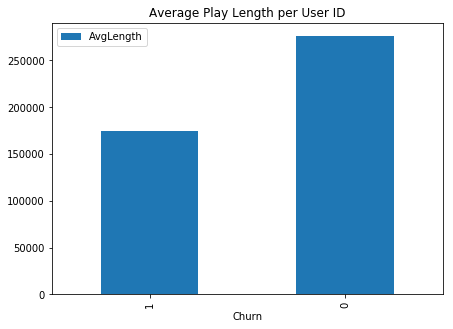

In [16]:
(average_song_length.select('Churn', 'AvgLength')
                .toPandas()
                .set_index('Churn')
                .plot(kind = 'bar', figsize = (7, 5), title = 'Average Play Length per User ID'))

In [17]:
# Creates pivoted table that counts page types by user id
userid_page_pivot = events.groupby(["userId"]).pivot("page").count().fillna(0)

In [18]:
userid_page_pivot = userid_page_pivot.toPandas()
userid_page_pivot.rename(columns={'Cancellation Confirmation': 'Churn'}, inplace = True)

In [19]:
userid_page_pivot

,userId,About,Add Friend,Add to Playlist,Cancel,Churn,Downgrade,Error,Help,Home,...,Register,Roll Advert,Save Settings,Settings,Submit Downgrade,Submit Registration,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,3,4,8,0,0,5,0,2,20,...,0,7,0,3,0,0,1,6,21,2
1,100010,1,4,7,0,0,0,0,2,11,...,0,52,0,0,0,0,0,5,17,2
2,125,0,0,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,51,2,28,52,1,1,23,1,12,75,...,0,0,1,12,0,0,0,21,100,0
4,124,7,74,118,0,0,41,6,23,176,...,0,4,6,20,0,0,0,41,171,0
5,7,0,1,5,0,0,0,1,1,10,...,0,16,1,3,0,0,0,1,7,2
6,54,5,33,72,1,1,39,1,17,129,...,0,47,3,17,1,0,1,29,163,1
7,15,2,31,59,0,0,28,2,8,93,...,0,1,2,16,0,0,0,14,81,0
8,155,2,11,24,0,0,12,3,9,30,...,0,8,0,5,0,0,1,3,58,2
9,132,4,41,38,0,0,19,3,16,83,...,0,2,4,17,0,0,1,17,96,1


In [20]:
plot_columns = userid_page_pivot.drop('Churn', axis = 1).columns

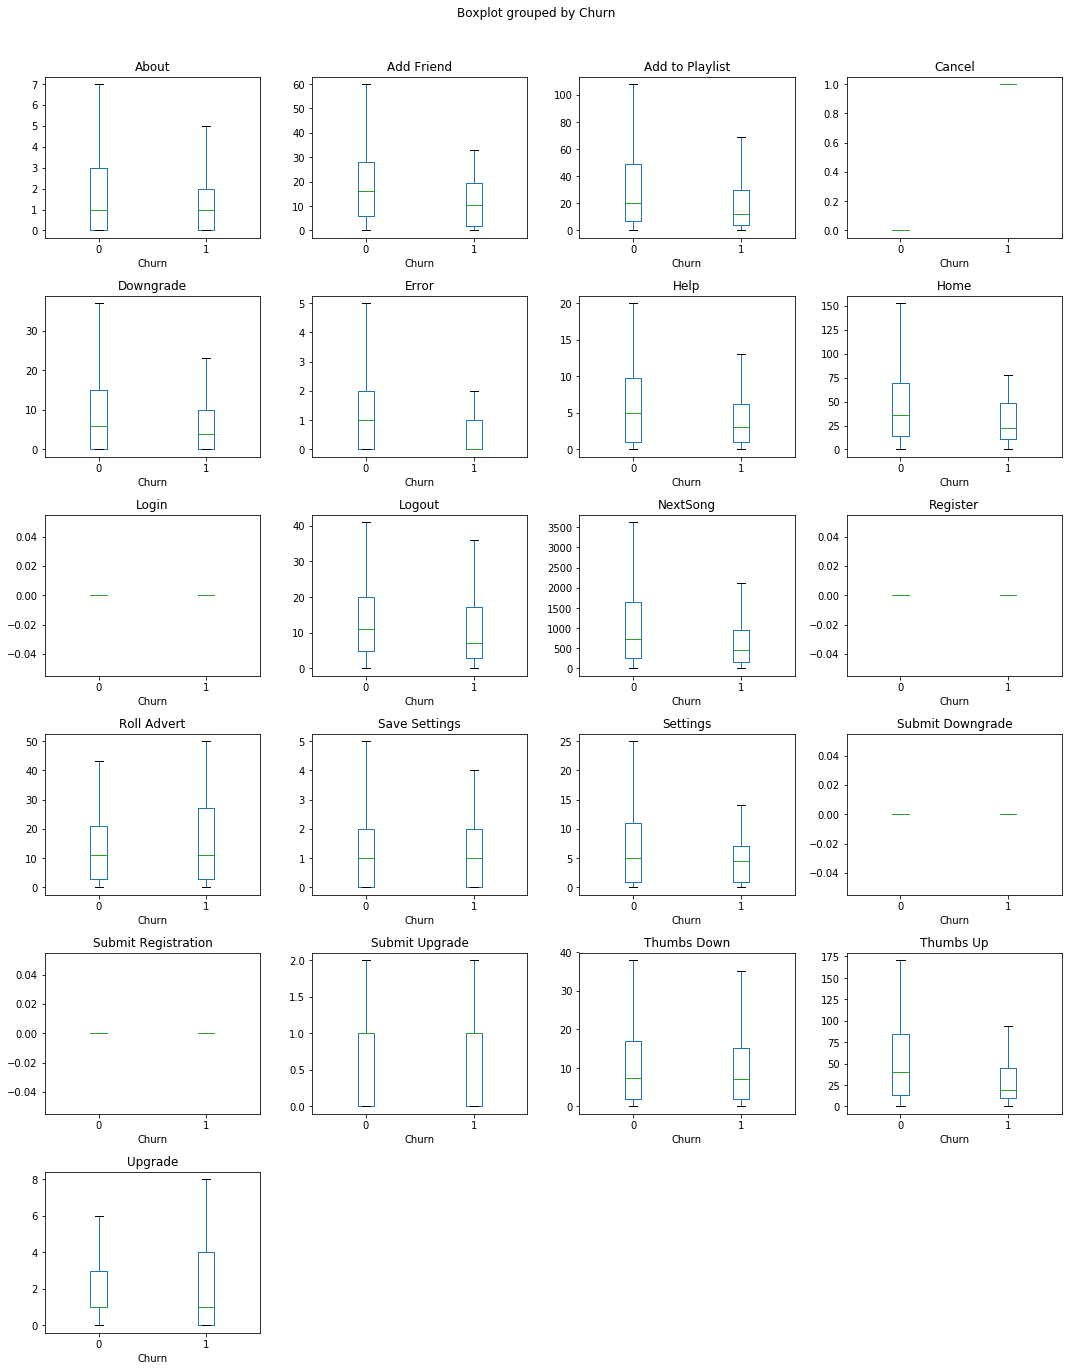

In [21]:
# Displays ranges, percentiles, and averages of users that churned vs those that did not churn per page type
fig = plt.figure(figsize=(15, 20))

for i in range(1,len(plot_columns)):
    axis = fig.add_subplot(6,4,i)
    userid_page_pivot.boxplot(plot_columns[i], ax = axis, 
                         grid = False,  by='Churn', showfliers=False)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
events_after_drops = events.drop('artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName', 'location', 'method', 'song',
                      'status', 'registration')

events_after_drops.toPandas()

,length,level,page,sessionId,ts,userAgent,userId,Churn
0,277.89016,paid,NextSong,29,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,236.09424,free,NextSong,8,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,282.82730,paid,NextSong,29,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,262.71302,free,NextSong,8,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,223.60771,paid,NextSong,29,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
5,208.29995,free,NextSong,8,1538352678000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
6,260.46649,free,NextSong,8,1538352886000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
7,185.44281,paid,NextSong,29,1538352899000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
8,NaN,paid,Add to Playlist,29,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
9,134.47791,paid,NextSong,29,1538353084000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [23]:
userid_page_pivot = events_after_drops.groupby(["userId"]).pivot("page").count().fillna(0)
userid_page_pivot = userid_page_pivot.drop('About', 'Cancel', 'Login', 'Save Settings', 'Submit Registration', 'Register')

userid_page_pivot.toPandas()

,userId,Add Friend,Add to Playlist,Cancellation Confirmation,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade
0,200002,4,8,0,5,0,2,20,5,387,7,3,0,1,6,21,2
1,100010,4,7,0,0,0,2,11,5,275,52,0,0,0,5,17,2
2,125,0,0,1,0,0,0,0,0,8,1,0,0,0,0,0,0
3,51,28,52,1,23,1,12,75,24,2111,0,12,0,0,21,100,0
4,124,74,118,0,41,6,23,176,59,4079,4,20,0,0,41,171,0
5,7,1,5,0,0,1,1,10,3,150,16,3,0,0,1,7,2
6,54,33,72,1,39,1,17,129,36,2841,47,17,1,1,29,163,1
7,15,31,59,0,28,2,8,93,27,1914,1,16,0,0,14,81,0
8,155,11,24,0,12,3,9,30,14,820,8,5,0,1,3,58,2
9,132,41,38,0,19,3,16,83,34,1928,2,17,0,1,17,96,1


In [24]:
# Filters "events_after_drops" data so that only pages that are "NextSong" are displayed
events_NextSong = events_after_drops.filter(events_after_drops.page == 'NextSong')

# Variable for total lengths of played songs
total_song_length = events_songs.groupby(events_NextSong.userId).agg(sum('length'))

# Joins "userid_page_pivot" table with "total_song_length" table
userid_page_pivot = (userid_page_pivot.join(total_song_length, on = 'userId', how = 'left')
                            .withColumnRenamed("Cancellation Confirmation", "Churn")
                            .withColumnRenamed("sum(length)", "total_song_length"))

In [25]:
# This variable converts to days
convert = 1000*60*60*24

# Finds the minimum and maximum timestamps of each user
min_timestamp = events_after_drops.select(["userId", "ts"]).groupby("userId").min("ts")
max_timestamp = events_after_drops.select(["userId", "ts"]).groupby("userId").max("ts")

# Determines active days per user
days_active = min_timestamp.join(max_timestamp, on="userId")
days_active = (days_active.withColumn("days_active", 
                                   (col("max(ts)")-col("min(ts)")) / convert))
days_active = days_active.select(["userId", "days_active"])

# Joins "userid_page_pivot" table with "daysActive" table
userid_page_pivot = userid_page_pivot.join(days_active, on = 'userId', how = 'left')

In [26]:
userid_page_pivot.toPandas()

,userId,Add Friend,Add to Playlist,Churn,Downgrade,Error,Help,Home,Logout,NextSong,Roll Advert,Settings,Submit Downgrade,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,total_song_length,days_active
0,100010,4,7,0,0,0,2,11,5,275,52,0,0,0,5,17,2,6.694090e+04,44.217801
1,200002,4,8,0,5,0,2,20,5,387,7,3,0,1,6,21,2,9.400888e+04,45.496806
2,125,0,0,1,0,0,0,0,0,8,1,0,0,0,0,0,0,2.089113e+03,0.020532
3,124,74,118,0,41,6,23,176,59,4079,4,20,0,0,41,171,0,1.012312e+06,59.996944
4,51,28,52,1,23,1,12,75,24,2111,0,12,0,0,21,100,0,5.232758e+05,15.779398
5,7,1,5,0,0,1,1,10,3,150,16,3,0,0,1,7,2,3.803409e+04,50.784051
6,15,31,59,0,28,2,8,93,27,1914,1,16,0,0,14,81,0,4.773076e+05,54.773183
7,54,33,72,1,39,1,17,129,36,2841,47,17,1,1,29,163,1,7.113449e+05,42.797199
8,155,11,24,0,12,3,9,30,14,820,8,5,0,1,3,58,2,1.987793e+05,25.827836
9,100014,6,7,1,3,0,2,7,3,257,2,1,0,0,3,17,0,6.770347e+04,41.244363


In [27]:
# New table that displauys distinct counts of sessionId per user
session_count = (events_after_drops.select(["userId", "sessionId"])
                      .distinct()
                      .groupby("userId")
                       .count()
                      .withColumnRenamed("count", "session_count"))

# Joins "userid_page_pivot" table with "numSessions" table
userid_page_pivot = userid_page_pivot.join(session_count, on = 'userId', how = 'left')

In [28]:
# Finds the minimum and maximum timestamps of each user with a "paid" level
paid_min_timestamp = events_after_drops.filter(events_after_drops.level == 'paid').groupby("userId").min("ts")
paid_max_timestamp = events_after_drops.filter(events_after_drops.level == 'paid').groupby("userId").max("ts")

# Determines the # of active days of users at the paid level
days_paid_table = paid_min_timestamp.join(paid_max_timestamp, on="userId")
days_paid_table = (days_paid_table.withColumn("days_paid", 
                                (col("max(ts)")-col("min(ts)")) / convert))
days_paid_table = days_paid_table.select(["userId", "days_paid"])

# Joins "userid_page_pivot" table with "daysPaid" table
userid_page_pivot = userid_page_pivot.join(days_paid_table, on = 'userId', how='left')

In [29]:
# Finds the minimum and maximum timestamps of each user with a "free" level
free_min_timestamp = events_after_drops.filter(events_after_drops.level == 'free').groupby("userId").min("ts")
free_max_timestamp = events_after_drops.filter(events_after_drops.level == 'free').groupby("userId").max("ts")

# Determines the # of active days of users at the free level
days_free_table = free_min_timestamp.join(free_max_timestamp, on="userId")
days_free_table = (days_free_table.withColumn("days_free", 
                                (col("max(ts)")-col("min(ts)")) / convert))
days_free_table = days_free_table.select(["userId", "days_free"])

# Joins "userid_page_pivot" table with "daysFree" table
userid_page_pivot = userid_page_pivot.join(days_free_table, on = 'userId', how='left')

In [30]:
# Creates table to display user agent info (browser, operating system, etc.)
user_agent_table = events_after_drops.select(['userId', 'userAgent']).distinct()
user_agent_table = user_agent_table.fillna('Unknown')

# Builds a string indexer to display multiple strings in each cell
string_indexer = StringIndexer(inputCol="userAgent", outputCol="user_agent_index")
model = string_indexer.fit(user_agent_table)
user_agent_table = model.transform(user_agent_table)

# Performs one hot encoding on "userAgents" table
encoder = OneHotEncoder(inputCol="user_agent_index", outputCol="user_agent_vector")
user_agent_table = encoder.transform(user_agent_table).select(['userId', 'user_agent_vector'])

# Joins "userid_page_pivot" table with "userAgents" table
userid_page_pivot = userid_page_pivot.join(user_agent_table, on = 'userId', how ='left')

In [31]:
userid_page_pivot = userid_page_pivot.fillna(0)

In [32]:
userid_page_pivot.toPandas()

,userId,Add Friend,Add to Playlist,Churn,Downgrade,Error,Help,Home,Logout,NextSong,...,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,total_song_length,days_active,session_count,days_paid,days_free,user_agent_vector
0,100010,4,7,0,0,0,2,11,5,275,...,0,5,17,2,6.694090e+04,44.217801,7,0.000000,44.217801,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,200002,4,8,0,5,0,2,20,5,387,...,1,6,21,2,9.400888e+04,45.496806,6,28.578646,16.916331,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,125,0,0,1,0,0,0,0,0,8,...,0,0,0,0,2.089113e+03,0.020532,1,0.000000,0.020532,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,124,74,118,0,41,6,23,176,59,4079,...,0,41,171,0,1.012312e+06,59.996944,29,59.996944,0.000000,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,51,28,52,1,23,1,12,75,24,2111,...,0,21,100,0,5.232758e+05,15.779398,10,15.779398,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,7,1,5,0,0,1,1,10,3,150,...,0,1,7,2,3.803409e+04,50.784051,7,0.000000,50.784051,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,15,31,59,0,28,2,8,93,27,1914,...,0,14,81,0,4.773076e+05,54.773183,15,54.773183,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,54,33,72,1,39,1,17,129,36,2841,...,1,29,163,1,7.113449e+05,42.797199,37,42.797199,13.981748,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,155,11,24,0,12,3,9,30,14,820,...,1,3,58,2,1.987793e+05,25.827836,6,19.409132,6.418067,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,100014,6,7,1,3,0,2,7,3,257,...,0,3,17,0,6.770347e+04,41.244363,6,41.244363,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [33]:
userid_page_pivot.columns

['userId',
 'Add Friend',
 'Add to Playlist',
 'Churn',
 'Downgrade',
 'Error',
 'Help',
 'Home',
 'Logout',
 'NextSong',
 'Roll Advert',
 'Settings',
 'Submit Downgrade',
 'Submit Upgrade',
 'Thumbs Down',
 'Thumbs Up',
 'Upgrade',
 'total_song_length',
 'days_active',
 'session_count',
 'days_paid',
 'days_free',
 'user_agent_vector']

In [34]:
# userid_page_pivot is exported to the main file directory as a csv file
userid_page_pivot.toPandas().to_csv(r'userid_page_pivot.csv')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [35]:
# Splits data into training and test sets
userid_page_pivot = userid_page_pivot.withColumnRenamed('Churn', 'label')
training_set, test_set = userid_page_pivot.randomSplit([0.8, 0.2])

In [36]:
# Training data
training_set.toPandas()

,userId,Add Friend,Add to Playlist,label,Downgrade,Error,Help,Home,Logout,NextSong,...,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,total_song_length,days_active,session_count,days_paid,days_free,user_agent_vector
0,200002,4,8,0,5,0,2,20,5,387,...,1,6,21,2,9.400888e+04,45.496806,6,28.578646,16.916331,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,125,0,0,1,0,0,0,0,0,8,...,0,0,0,0,2.089113e+03,0.020532,1,0.000000,0.020532,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,124,74,118,0,41,6,23,176,59,4079,...,0,41,171,0,1.012312e+06,59.996944,29,59.996944,0.000000,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,51,28,52,1,23,1,12,75,24,2111,...,0,21,100,0,5.232758e+05,15.779398,10,15.779398,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,7,1,5,0,0,1,1,10,3,150,...,0,1,7,2,3.803409e+04,50.784051,7,0.000000,50.784051,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,15,31,59,0,28,2,8,93,27,1914,...,0,14,81,0,4.773076e+05,54.773183,15,54.773183,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,54,33,72,1,39,1,17,129,36,2841,...,1,29,163,1,7.113449e+05,42.797199,37,42.797199,13.981748,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,132,41,38,0,19,3,16,83,34,1928,...,1,17,96,1,4.831189e+05,50.497407,16,50.416331,0.080683,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,154,3,1,0,0,0,1,6,2,84,...,0,0,11,0,2.066002e+04,24.986458,3,0.000000,24.986458,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,101,29,61,1,22,3,12,74,24,1797,...,1,16,86,1,4.474640e+05,15.861481,10,14.193137,1.666273,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [37]:
# Test data
test_set.toPandas()

,userId,Add Friend,Add to Playlist,label,Downgrade,Error,Help,Home,Logout,NextSong,...,Submit Upgrade,Thumbs Down,Thumbs Up,Upgrade,total_song_length,days_active,session_count,days_paid,days_free,user_agent_vector
0,100010,4,7,0,0,0,2,11,5,275,...,0,5,17,2,6.694090e+04,44.217801,7,0.000000,44.217801,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
1,155,11,24,0,12,3,9,30,14,820,...,1,3,58,2,1.987793e+05,25.827836,6,19.409132,6.418067,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,100014,6,7,1,3,0,2,7,3,257,...,0,3,17,0,6.770347e+04,41.244363,6,41.244363,0.000000,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,29,47,89,1,18,0,28,121,41,3028,...,1,22,154,5,7.545176e+05,43.320926,34,36.620903,6.699988,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,64,5,1,0,0,0,1,7,3,46,...,0,0,4,0,1.153035e+04,23.300081,3,0.000000,23.300081,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,133,1,3,0,0,0,0,3,2,32,...,0,0,2,0,8.029164e+03,0.120741,1,0.000000,0.120741,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,300018,35,58,0,9,2,16,84,24,1640,...,1,24,132,1,4.150803e+05,50.649896,28,46.271632,4.378009,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,52,40,33,0,10,0,7,54,20,1086,...,1,9,54,3,2.674264e+05,58.051424,15,26.493704,31.553877,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,100008,17,30,0,10,0,6,24,7,772,...,0,6,37,4,1.913968e+05,48.999479,6,42.213391,6.784410,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,47,0,3,0,0,0,1,11,4,202,...,0,2,10,0,4.897799e+04,43.060475,9,0.000000,43.060475,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [38]:
# Creates vector from feature data
feature_names = userid_page_pivot.drop('label', 'userId').schema.names
vec_asembler = VectorAssembler(inputCols = feature_names, outputCol = "Features")

# Scales each column
scalar = MinMaxScaler(inputCol="Features", outputCol="ScaledFeatures")



In [39]:
# Intializes classifiers
lr = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", 
                        maxIter=10, regParam=0.02)

rf = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label",
                                numTrees = 25,  featureSubsetStrategy='sqrt')

gbt = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label")

# Constructs three pipelines
pipeline_lr = Pipeline(stages=[vec_asembler, scalar, lr])
pipeline_rf = Pipeline(stages=[vec_asembler, scalar, rf])
pipeline_gbt = Pipeline(stages=[vec_asembler, scalar, gbt])

In this cell, I'll explain why I chose the hyperparameters for the three models above.

**LogisticRegression:**
I chose 10 maximum iterations to strike the right balance between the number iterations that can generate an adequate f1 score and a training time that was reasonable. 

I chose 0.2 for the regularization parameter. That is because having a value of 0.1 may run the risk of having a model that is too complex and overfits the data. A value of 0.3 may run the risk of having a model that is too simple and underfits the data.

**RandomForestClassifier:**
I chose 25 for the number of trees because I wanted to maximize the prediction results. However, I would have chosen a much higher number of trees if it weren't for the increased training time that would have caused. 

Although this wasn't required, I chose "sqrt" for featureSubsetStrategy to clearly show what value is being used. The value for "featureSubsetStrategy" is specified as a fraction or function of the total number of features to use as candidates for splitting at each tree node...leading to a higher number of accurate predictions. Choosing "auto" would have resulted in the model automatically reverting to "sqrt" since the number of trees is over 1 and this Random Forest model is a classifier instead of a regressor.

Sources:

https://spark.apache.org/docs/latest/mllib-ensembles.html

https://spark.apache.org/docs/1.4.0/api/java/org/apache/spark/mllib/tree/RandomForest.html

**GBTClassifier:**
I chose the default hyperparameters for the Gradient-Boosted Tree classifier to minimize the overall training times in this Python script.

In [40]:
# Creates "Features" outcome column, scales data, and fits each model to the data
lr_model = pipeline_lr.fit(training_set)
rf_model = pipeline_rf.fit(training_set)
gbt_model = pipeline_gbt.fit(training_set)

In [41]:
# This function generates predictions, calculates f1 scores, returns a f1 score, and returns a confusion matrix
def modelEvaluations(model, metric, data):
    """ Evaluate a machine learning model's performance 
        Input: 
            model - pipeline object
            metric - the metric of the evaluations
            data - data being evaluated
        Output:
            [score, confusion matrix]
    """
    # generates predictions
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    predictions = model.transform(data)
    
    # calculates score
    score = evaluator.evaluate(predictions)
    confusion_matrix = (predictions.groupby("label")
                                   .pivot("prediction")
                                   .count()
                                   .toPandas())
    return [score, confusion_matrix]

In [42]:
# Assigns f1 results of the above function to variables
f1_lr, confusion_matrix_lr = modelEvaluations(lr_model, 'f1', test_set)
f1_rf, confusion_matrix_rf = modelEvaluations(rf_model, 'f1', test_set)
f1_gbt, confusion_matrix_gbt = modelEvaluations(gbt_model, 'f1', test_set)

In [43]:
# Assigns accuracy results of the above function to variables
accuracy_lr, confusion_matrix_lr = modelEvaluations(lr_model, 'accuracy', test_set)
accuracy_rf, confusion_matrix_rf = modelEvaluations(rf_model, 'accuracy', test_set)
accuracy_gbt, confusion_matrix_gbt = modelEvaluations(gbt_model, 'accuracy', test_set)

In [44]:
print('The F1 score for the Logistics Regression Classifier model is ', f1_lr)
print('The accuracy for the Logistics Regression Classifier model is ', accuracy_lr)
confusion_matrix_lr

The F1 score for the Logistics Regression Classifier model is  0.7522728943563605
The accuracy for the Logistics Regression Classifier model is  0.7441860465116279


,label,0.0,1.0
0,0,31,6
1,1,5,1


In [45]:
print('The F1 score for the Random Forest Classifier model is ', f1_rf)
print('The accuracy for the Random Forest Classifier model is ', accuracy_rf)
confusion_matrix_rf

The F1 score for the Random Forest Classifier model is  0.9199637571730594
The accuracy for the Random Forest Classifier model is  0.9302325581395349


,label,0.0,1.0
0,0,37,NaN
1,1,3,3.0


In [46]:
print('The F1 score for the Gradient Boosting Classifier model is ', f1_gbt)
print('The accuracy for the Gradient Boosting Classifier model is ', accuracy_gbt)
confusion_matrix_gbt

The F1 score for the Gradient Boosting Classifier model is  0.7959416324669402
The accuracy for the Gradient Boosting Classifier model is  0.7674418604651163


,label,0.0,1.0
0,0,29,8
1,1,2,4


In the section above, I used the F1 scores and accuracies to score each model. The F1 score is the average of the precision and recall, where 1 represents a perfect precision and recall and 0 is the lowest possible score. 

The F1 score is usually more reliable than accuracy. That is because accuracy is only an ideal measure when you have symmetric datasets where values of false positive and false negatives are almost the same. In the three confusion matrices above, you can see in the top-right and bottom-left sections of the grids that the numbers are not almost the same in all three cases.

Below, I will display the equations for F1 score, accuracy, precision, and recall as a reference:

**F1 score** is the average of the precision and recall.

*[(2*(Precision*Recall)/(Precision+Recall))]*

**Accuracy** is the ratio of correctly predicted observations to  total observations.

*[(True Positives + False Negatives)/All Observations]*

**Precision** is the ratio of true positives to true positives and false positives.

*[True Positives/(True Positives + False Positives)]*

**Recall (sensitivity)** is the ratio of true positives to true postiives AND false negatives.

*[True Positives/(True Positives + False Negatives)]*


The **Gradient-Boost Tree model** typically has the highest F1 score in this project. However, each time I train the models in this notebook, the results vary. I will tune the hyperparameters of the Gradient-Boost Tree model in the next session since that model typically performs the best out of all three models.


Source:
https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance-measures/

https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9

# Improvements
In this section, I'm tuning the hyperparameters for the Gradient-Boost Tree model. I'm testing 5 and 10 for the max depth for this model and I'm using 2 folds in the cross validator.

In [47]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


GBTClassifier(maxIter=10,seed=42)

paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth,[5, 10]) \
    .addGrid(gbt.maxIter,[5, 10]) \
    .build()

crossval = CrossValidator(estimator=pipeline_gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3) 

In [48]:
cvModel_gbt = crossval.fit(training_set)

In [49]:
cvModel_gbt.avgMetrics

[0.7878065142300636,
 0.7878065142300636,
 0.7828570606348384,
 0.7828570606348384]

In [50]:
# results_final = cvModel_gbt.transform(test_set)

In [51]:
"""
print(results_final.filter(results_final.label == results_final.prediction).count())
print(results_final.count())
"""

'\nprint(results_final.filter(results_final.label == results_final.prediction).count())\nprint(results_final.count())\n'

In [52]:
# 43/48

In [53]:
gbt_optimized = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label", maxIter=10, maxDepth=5, seed=67)

pipeline_gbt_optimized = Pipeline(stages=[vec_asembler, scalar, gbt_optimized])

gbt_optimized_model = pipeline_gbt_optimized.fit(training_set)
results_final = gbt_optimized_model.transform(test_set)

In [54]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test Set Prediction Metrics:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))
print('Accuracy: {}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "accuracy"})))

Test Set Prediction Metrics:
F-1 Score:0.8183196623979246
Accuracy: 0.7906976744186046


Above, you can see that I tested 5 and 10 for the max depth and max iterations hyperparameters for the Gradient-Boost Tree model and used 3 folds in the cross validator. I ultimately chose 10 for max iterations and 5 for max depth because of the results from the cross validation. I found that the F1 score increased by 2.2% to 81.8% and the accuracy increased by 2.4% to 79.1%. 

# Feature Importance

In [56]:
# Displays features that are most predictive of the label in the model
feature_importances = np.array(gbt_optimized_model.stages[-1].featureImportances)
userAgentVec = feature_importances[len(feature_names) :].sum()
feature_importances = feature_importances[:len(feature_names)] + [userAgentVec]

In [57]:
# Converts feature importance data to a pandas dataframe
feature_importance = pd.DataFrame(feature_importances, 
                                     index = feature_names,
                                     columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

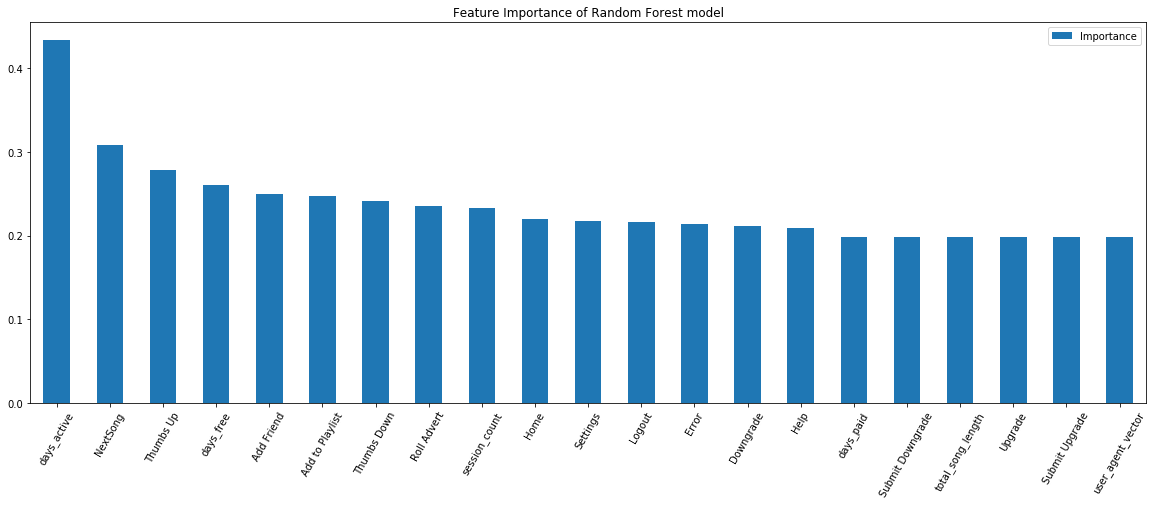

In [58]:
feature_importance.plot(kind = 'bar', figsize = (20, 7), title = 'Feature Importance of Random Forest model')
plt.xticks(rotation = 60)

In [59]:
# feature_importance is exported to the main file directory as a csv file
feature_importance.to_csv(r'feature_importance.csv')

# Conclusion
The primary purpose of this project was to correctly identify users that churned and to determine the best machine learning model to predict churned users. The Gradient-Boost Tree model typically has the highest f1 score out of the three models I tested when I run the cells in the Jupyter Notebook file. I later improved the Gradient-Boost Tree model and generated a higher F1 score and accuracy after testing two max depth values and using 3 folds in a cross validator.

At the end of the project, I displayed the features that were most predictive in the Gradient-Boost Tree model and found that these four features had noticeably higher importance values than the other features: days_active, NextSong, Thumbs Up, and days_free. The first three features makes sense because churned users would naturally have lower values for those features than users who decide to use the music service considerably longer.

One of the most difficult aspects of the project was enduring the long training times for the models. The training times ranged from 40 minutes to two hours. It would have been great to test a higher range of hyperparameters to maximize the F1 score and accuracy in the final optimized model, but the training times were restrictive.

Overall, this was a great opportunity to apply machine learning techniques with PySpark to an immensely important use case for many companies.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.